# Build Dataset
In this notebook the build dataset function, needed for the datapipeline is implemented

This notebook is inspired by and partly copied from https://www.kaggle.com/code/wengsilu/birdclef24pretraining

### Imports

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import librosa
from IPython.display import Audio

import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)

import tensorflow_io as tfio
import tensorflow_extra as tfe
import tensorflow_probability as tfp

2024-07-01 18:51:48.229830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 18:51:48.229884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 18:51:48.230990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 18:51:48.238105: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 18:51:49.042562: W tensorflow/compiler/tf2

## Set device and strategy
If GPUs are available, use them

In [2]:
#tf.config.set_visible_devices([], 'GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_logical_devices('GPU')
ngpu = len(gpus) # Check number of GPUs
if ngpu:
    # Set GPU strategy
    strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
    # Print GPU details
    print("> Running on GPU", end=' | ')
    print("Num of GPUs: ", ngpu)
    device='GPU'
else:
    # If no GPUs are available, use CPU
    print("> Running on CPU")
    strategy = tf.distribute.get_strategy()
    device='CPU'

Num GPUs Available:  1
> Running on GPU | Num of GPUs:  1


2024-07-01 18:51:50.337289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 18:51:50.367993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 18:51:50.368397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 18:51:50.370964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-01 18:51:50.371896: I external/local_xla/xla/stream_executor

## Load dataframe (for testing)

In [3]:
df = pd.read_csv("../../data/dataset10.csv")
df["fullfilename"] = "../" + df["fullfilename"]

## Configurations

In [4]:
class cfg:
    # random seed
    seed = 42

    # audio clip settings
    sr = 24000
    duration = 15 # the duration of the clips
    desired_length = duration*sr
    
    n_samples = duration*sr
    hop_length = 2048 # "stepsize" of the fft for the melspectrograms
    nfft = 4096 # windowsize of the fft for the melspectrograms
    n_mels = 128 # number of mel frequency bins
    fmax = sr/2 # maximum frequency in the melspectrograms
    input_dim = (int(duration*sr/hop_length + 1), n_mels)
    
    # data processing settings
    batch_size = 5
    shuffle_buffer = 5 # idk Number of elements from the dataset to buffer for shuffling.
    
    # class labels/names
    names = list(np.unique(df.en))
    num_classes = len(names)
    labels = list(range(num_classes))
    label2name = dict(zip(labels, names))
    name2label = {v:k for k,v in label2name.items()}

    # set device
    device = device

# set random seed in keras
tf.keras.utils.set_random_seed(cfg.seed)

# Function to load and prepare audio files

In [5]:
def check_files(df):
    drop_indices = []
    for i in tqdm(range(len(df))):
        filepath = df.iloc[i].fullfilename
        try:
            audio = tfio.audio.AudioIOTensor(filepath, dtype = tf.float32) # lazy load the file
        except Exception as e:
            print(f"Error loading audio file {filepath} with TensorFlow I/O: {e}")
            print("Deleting file from dataframe.")
            drop_indices.append(i)
        if audio.shape[0] == 0:
            print(f"Failed to load audio file {filepath} with TensorFlow I/O: shape[0] = 0")
            print("Deleting file from dataframe.")
            drop_indices.append(i)
    df.drop(index = drop_indices, inplace = True)

In [6]:
print(len(df))
check_files(df)
print(len(df))

300


  0%|                                                                                           | 0/300 [00:00<?, ?it/s]2024-07-01 18:51:50.850932: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-07-01 18:51:50.855235: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
 55%|████████████████████████████████████████████▌                                    | 165/300 [00:02<00:01, 73.88it/s]

Failed to load audio file ../../data/dataset10/Troglodytes troglodytes_Eurasian Wren/XC845049.mp3 with TensorFlow I/O: shape[0] = 0
Deleting file from dataframe.


 87%|██████████████████████████████████████████████████████████████████████▏          | 260/300 [00:04<00:00, 71.75it/s]

Error loading audio file ../../data/dataset10/Luscinia megarhynchos_Common Nightingale/XC899978.mp3 with TensorFlow I/O: {{function_node __wrapped__IO>AudioReadableInit_device_/job:localhost/replica:0/task:0/device:CPU:0}} Read less bytes than requested [Op:IO>AudioReadableInit]
Deleting file from dataframe.


100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 63.79it/s]

298


In [7]:
# Generates random integer # from https://www.kaggle.com/code/wengsilu/birdclef24pretraining
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)

# Generats random float
def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

In [8]:
def audio_loader(with_labels = True, cfg = cfg, num_classes = cfg.num_classes):
    #def slow_load(filepath):
    #    audio, sr = librosa.load(filepath, sr = cfg.sr)
    #    # randomly pad clip if shorter
    #    if len(audio) < cfg.duration*sr:
    #        _ = np.zeros(window*sr)
    #        rdm = random_int(maxval = cfg.duration*sr-len(audio))
    #        _[rdm:rdm + len(audio)] = audio
    #        audio = _
    #    else: # select random window if clip longer
    #        rdm = random_int(maxval = len(audio) - cfg.duration*sr)
    #        audio = audio[rdm:rdm + cfg.duration*sr]
    #    audio = tf.convert_to_tensor(audio, dtype = tf.float32)
    #    return audio
    
    def decode(filepath):
        # read audio
        #try:
        audio = tfio.audio.AudioIOTensor(filepath, dtype = tf.float32) # lazy load the file
        #except Exception as e:
        #    print(f"Error loading audio file {filepath} with TensorFlow I/O: {e}")
        #    print("Proceeding to slow load file")
        #    return slow_load(filepath)
        #if audio.shape[0] == 0:
        #    print(f"Failed to load audio file {filepath.numpy} with TensorFlow I/O: shape[0] = 0")
        #    print("Proceeding to slow load file")
        #    return slow_load(filepath)
        
        rate = audio.rate
        # cut out clip of specified duration at random position
        num_samples = cfg.duration*rate
        length = tf.cast(audio.shape[0], tf.int32)
        if num_samples < length:
            rdm = random_int(maxval = length - num_samples)
            audio = audio[rdm:rdm+num_samples]
        else:
            audio = audio.to_tensor()
        audio = tf.cast(audio, tf.float32)
        # resample if necessary
        audio = tfio.audio.resample(audio, tf.cast(rate, tf.int64), cfg.sr) if rate != cfg.sr else audio
        # remove noise (tfio.audio.split() or tfio.audio.trim()?)# can't do this when the clip is already cut
        # stereo to mono
        audio = tf.reduce_mean(audio, axis=-1) if tf.shape(audio)[-1] == 2 else tf.squeeze(audio, axis = -1)
        # pad if necessary
        if tf.size(audio) < cfg.desired_length:
            missing = cfg.desired_length - tf.size(audio)
            rdm = random_int(maxval = missing)
            audio = tf.pad(audio, [[rdm, missing-rdm]]) # pad rdm zeros left and missing-rdm zeros rigth
        audio = tf.reshape(audio, [cfg.sr*cfg.duration])
        return audio

    def get_target(target):          
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, num_classes), tf.float32) 
        target = tf.reshape(target, [num_classes])
        return target
    
    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode

# Build dataset

In [9]:
def build_dataset(paths, labels=None, batch_size=cfg.batch_size,
                  audio_decode_fn=None,
                  num_classes=cfg.num_classes,
                  cache=True, cache_dir="", drop_remainder=False,
                  repeat=True, shuffle=cfg.shuffle_buffer):
    """
    Creates a TensorFlow dataset from the given paths and labels.
    
    Args:
        paths (list): A list of file paths to the audio files.
        labels (list): A list of corresponding labels for the audio files.
        batch_size (int): Batch size for the created dataset.
        audio_decode_fn (function): A function to decode the audio file.
        cache (bool): Whether to cache the dataset or not.
        cache_dir (str): Directory path to cache the dataset.
        drop_remainder (bool): Whether to drop the last batch if it is smaller than batch_size.
        repeat (bool): Whether to repeat the dataset or not.
        shuffle (int): Number of elements from the dataset to buffer for shuffling.
        
    Returns:
        ds (tf.data.Dataset): A TensorFlow dataset.
    """
    # Create cache directory if cache is enabled
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    # Set default audio decode function if not provided
    if audio_decode_fn is None:
        audio_decode_fn = audio_loader(with_labels = labels is not None, cfg = cfg, num_classes = cfg.num_classes)
        
    # Set TensorFlow AUTOTUNE option
    #AUTO = tf.data.experimental.AUTOTUNE # hopefully optimizes data pipeline and decreases loading times
    #print(AUTO)
    # Create slices based on whether labels are provided
    slices = (paths,) if labels is None else (paths, labels)
    # Create TensorFlow dataset from slices
    ds = tf.data.Dataset.from_tensor_slices(slices)
    # Map audio decode function to dataset
    ds = ds.map(audio_decode_fn, num_parallel_calls=1)
    # Cache dataset in memory if cache is enabled
    ds = ds.cache(cache_dir) if cache else ds
    # Repeat dataset indefinitely if repeat is enabled
    ds = ds.repeat() if repeat else ds
    # Create TensorFlow dataset options
    opt = tf.data.Options()
    # Shuffle dataset if shuffle is enabled
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=cfg.seed)
        opt.experimental_deterministic = False
    if cfg.device=='GPU':
        # If the device is a GPU, turn off auto-sharding to avoid performance issues
        opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    # Set the options for the dataset
    ds = ds.with_options(opt)
    # Batch the dataset with the specified batch size
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    # Prefetch the next batch of data to improve performance
    #ds = ds.prefetch()
    return ds

In [10]:
df_sample = df.sample(frac=0.03, replace=False, random_state=cfg.seed)
paths = df_sample.fullfilename.tolist()
names = df_sample.en.tolist()
labels = []
for name in names:
    labels.append(cfg.name2label[name])

ds = build_dataset(paths, labels, cache=True)

2024-07-01 18:51:56.315497: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [11]:
import matplotlib.pyplot as plt

def plot_batch(batch, row=2, col=2, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        audios, tars = batch
    else:
        audios = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        plt.plot(audios[idx].numpy())
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

In [12]:
ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 360000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [13]:
audios, labels = next(iter(ds))

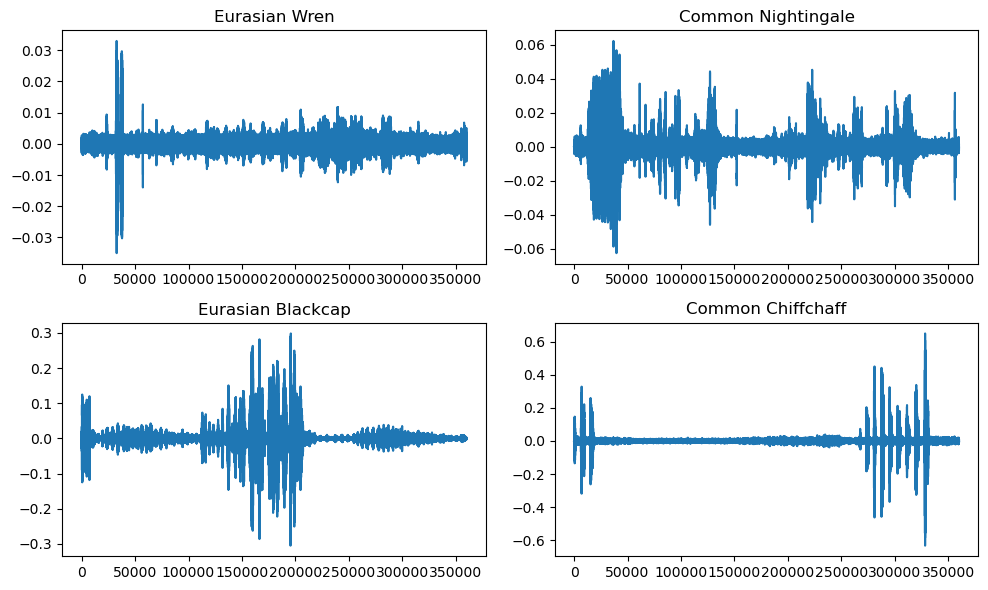

In [14]:
plot_batch((audios, labels), label2name=cfg.label2name)

In [15]:
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input

melspec_layer = tfe.layers.MelSpectrogram(n_fft=cfg.nfft, 
                                          hop_length=cfg.hop_length, 
                                          sr=cfg.sr, 
                                          fmin=0,
                                          fmax=cfg.fmax,
                                         )

class ExpandDimsLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

zscore_layer = tfe.layers.ZScoreMinMax()

def build_model():
    inp = Input(shape=(cfg.n_samples,))
    
    # Spectrogram
    x = melspec_layer(inp)
    
    # Normalize
    x = zscore_layer(x)
    
    # Add a channel dimension
    x = ExpandDimsLayer(axis=-1)(x)
    
    # Base model
    x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    #x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    #x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.num_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Basemodel")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
model = build_model()
model.summary()

Model: "Basemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360000)]          0         
                                                                 
 mel_spectrogram (MelSpectr  (None, 128, 176)          0         
 ogram)                                                          
                                                                 
 z_score_min_max (ZScoreMin  (None, 128, 176)          0         
 Max)                                                            
                                                                 
 expand_dims_layer (ExpandD  (None, 128, 176, 1)       0         
 imsLayer)                                                       
                                                                 
 conv2d (Conv2D)             (None, 126, 174, 32)      320       
                                                         

In [17]:
from sklearn.model_selection import train_test_split
id_train, id_val, y_train, y_val = train_test_split(range(len(df)), df["en"].to_list(), test_size = 0.3, random_state = cfg.seed)

paths_train = list(df.iloc[id_train].fullfilename)
paths_val = list(df.iloc[id_val].fullfilename)

label_train = []
for y in y_train:
    label_train.append(cfg.name2label[y])
label_val = []
for y in y_val:
    label_val.append(cfg.name2label[y])

In [18]:
train_ds = build_dataset(paths_train, label_train, shuffle = True, cache = False)
valid_ds = build_dataset(paths_val, label_val, shuffle = False)

In [ ]:
#try:
history = model.fit(
    train_ds, 
    epochs=2, 
    validation_data=valid_ds,
    steps_per_epoch=len(paths_train)//cfg.batch_size
    )
#except Exception as e:
#    print(f"Ich will nicht mehr: {e}")

Epoch 1/2


In [ ]:
def slow_load(filepath):
    audio, sr = librosa.load(filepath, sr = cfg.sr)
     # randomly pad clip if shorter
    if len(audio) < cfg.duration*sr:
        _ = np.zeros(window*sr)
        rdm = random_int(maxval = cfg.duration*sr-len(audio))
        _[rdm:rdm + len(audio)] = audio
        audio = _
    else: # select random window if clip longer
        rdm = random_int(maxval = len(audio) - cfg.duration*sr)
        audio = audio[rdm:rdm + cfg.duration*sr]
    audio = tf.convert_to_tensor(audio, dtype = tf.float32)
    return audio
    
def decode(filepath):
        # read audio
        try:
            audio = tfio.audio.AudioIOTensor(filepath, dtype = tf.float32) # lazy load the file
        except Exception as e:
            print(f"Error loading audio file {filepath} with TensorFlow I/O: {e}")
            print("Proceeding to slow load file")
            return slow_load(filepath)
        if audio.shape[0] == 0:
            print("Failed to load audio with TensorFlow I/O: shape[0] = 0")
            print("Proceeding to slow load file")
            return slow_load(filepath)
        rate = audio.rate
        # cut out clip of specified duration at random position
        num_samples = cfg.duration*rate
        length = tf.cast(audio.shape[0], tf.int32)
        if num_samples < length:
            rdm = random_int(maxval = length - num_samples)
            audio = audio[rdm:rdm+num_samples]
        else:
            audio = audio.to_tensor()
        audio = tf.cast(audio, tf.float32)
        # resample if necessary
        audio = tfio.audio.resample(audio, tf.cast(rate, tf.int64), cfg.sr) if rate != cfg.sr else audio
        # remove noise (tfio.audio.split() or tfio.audio.trim()?)# can't do this when the clip is already cut
        # stereo to mono
        audio = tf.reduce_mean(audio, axis=-1) if tf.shape(audio)[-1] == 2 else tf.squeeze(audio, axis = -1)
        # pad if necessary
        if tf.size(audio) < cfg.desired_length:
            missing = cfg.desired_length - tf.size(audio)
            rdm = random_int(maxval = missing)
            audio = tf.pad(audio, [[rdm, missing-rdm]]) # pad rdm zeros left and missing-rdm zeros rigth
        #audio = tf.reshape(audio, [cfg.sr*cfg.duration])
        return audio



In [ ]:
for path in tqdm(paths_train):
    audio = decode(path)

In [ ]:
audio = slow_load(paths_train[71]).numpy()

In [ ]:
audio.shape

In [ ]:
Audio(data = audio, rate = cfg.sr)

In [ ]:
audio = decode(paths_train[71]).numpy()

In [ ]:
audio.shape

In [ ]:
def get_audio(filepath):
    file_bytes = tf.io.read_file(filepath)
    audio = tfio.audio.decode_wav(file_bytes, dtype=tf.int64) # decode .mp3 file
    audio = tf.cast(audio, tf.float32)
    if tf.shape(audio)[1]>1: # stereo -> mono
        audio = audio[...,0:1]
    audio = tf.squeeze(audio, axis=-1)
    return audio

In [ ]:
from pydub import AudioSegment
import mutagen

# Using pydub
#audio = AudioSegment.from_file(paths_train[81])
#print(f"Channels: {audio.channels}, Frame Rate: {audio.frame_rate}")

# Using mutagen
mp3_info = mutagen.File(paths_train[71], easy=True)
print(mp3_info.info)